# Import Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread,imsave
import os
import pandas as pd
import scipy
from scipy.fftpack import dct, idct
from tqdm import tqdm 

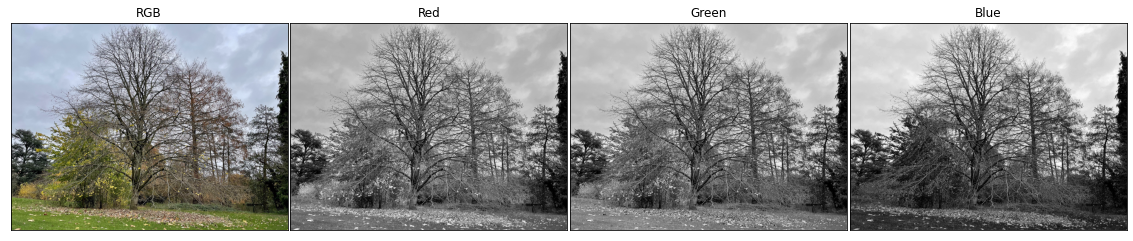

(3024, 4032, 3)


In [7]:
PATH = "drive/MyDrive/PY/2020_Projects/ImgAnalysis/ImgCompress/2020_images_BMP"
FILE = "IC5.bmp"
# test one image first
img = imread(os.path.join(PATH,FILE))

# plot RGB and each channel
plt.figure(figsize=(20, 4))
plt.subplots_adjust(wspace=0.01, hspace=0.08)
plt.subplot('141')
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.title('RGB')
plt.subplot('142')
plt.imshow(img[:,:,0],cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Red')
plt.subplot('143')
plt.imshow(img[:,:,1],cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Green')
plt.subplot('144')
plt.imshow(img[:,:,2],cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Blue')
plt.show()
print(img.shape)

In [8]:
# Transorm to YCbCr
# code from https://stackoverflow.com/questions/34913005/color-space-mapping-ycbcr-to-rgb
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

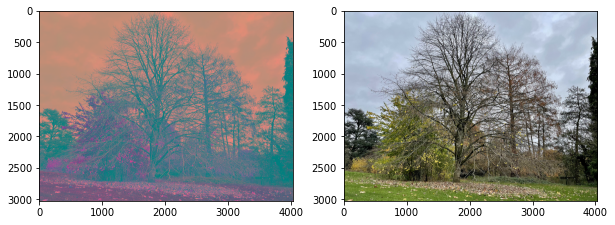

In [9]:
img_ycbcr = rgb2ycbcr(img) # convert to ycbcr
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.imshow(img_ycbcr)
plt.subplot('122')
plt.imshow(ycbcr2rgb(img_ycbcr)) # convert back to rgb

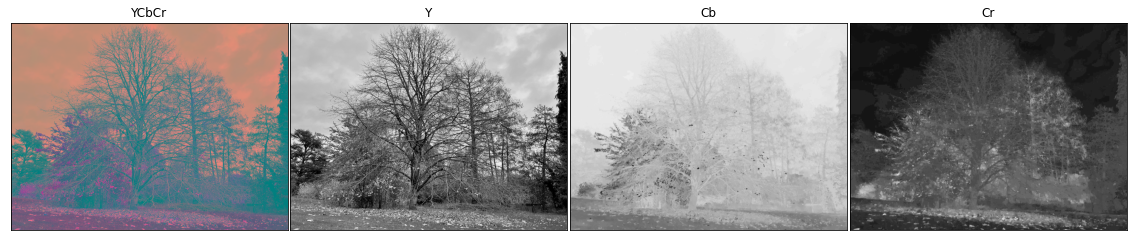

In [10]:
# plot YCbCr and each channel
plt.figure(figsize=(20, 4))
plt.subplots_adjust(wspace=0.01, hspace=0.08)
plt.subplot('141')
plt.imshow(img_ycbcr)
plt.xticks([]), plt.yticks([])
plt.title('YCbCr')
plt.subplot('142')
plt.imshow(img_ycbcr[:,:,0],cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Y')
plt.subplot('143')
plt.imshow(img_ycbcr[:,:,1],cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Cb')
plt.subplot('144')
plt.imshow(img_ycbcr[:,:,2],cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Cr')
plt.show()

# Define Metrics

In [56]:
# Mean suqred error (MSE) 
def mse(img_1, img_2):
    return np.sum((img_1-img_2) ** 2)/(img_1.shape[0]*img_1.shape[1])

# root mean-squared error (NRMSE) (0-1), higher the NRMSE, the bigger the difference 
from skimage.metrics import normalized_root_mse
def nrmse(img_1, img_2):
    return normalized_root_mse(img_1, img_2)

#SSIM (0-1), higher the SSIM, higher similarity
from skimage.metrics import structural_similarity
def ssim(img_1, img_2):
    return structural_similarity(img_1, img_2, data_range=img_2.max() - img_2.min(), multichannel=True)

# peak signal to noise ratio (PSNR) higher the PSNR, the higher the similarity. Infinate value refers to the identical images
from skimage.metrics import peak_signal_noise_ratio
def psnr(img_1, img_2):
    return peak_signal_noise_ratio(img_1.astype('uint8'), img_2.astype('uint8'), data_range=None)

def printAll(img_1, img_2): 
# first column is the original value, the second column uses a graylevel scaler on the img_1 only.
# the img_2 is the reference image which is not scaled, since it is the "test set" or "perfect image")
    cols = ['MSE','NRMSE','SSIM','PSNR']
    return pd.DataFrame([[mse(img_1, img_2), nrmse(img_1, img_2), ssim(img_1, img_2), psnr(img_1, img_2)]], columns=cols )

def minMaxScaler(X,min=0,max=255): # define a scaler
  X = X.astype("float")
  X_std = (X - X.min()) / (X.max() - X.min())
  X_scaled = X_std * (max - min) + min
  return X_scaled

# Explore DCT-based Compression

In [16]:
# Define 2D DCT and IDCT
def dct2(img): # default type 2 dft
    return dct(dct(img, axis=0, norm='ortho'), axis=1, norm='ortho' )

def idct2(img):
    return idct(idct(img, axis=0 , norm='ortho'), axis=1 , norm='ortho')

In [17]:
# Perform a blockwise DCT, default 8*8 block
def dctBlock(img, step=8): 
  imsize = img.shape
  dct_img = np.zeros(imsize)
  # for each 8x8 block 
  for i in np.r_[:imsize[0]:step]:
    for j in np.r_[:imsize[1]:step]:
      dct_img[i:(i+step),j:(j+step)] = dct2(img[i:(i+step),j:(j+step)])
  return dct_img

# Threshold DCT coefficients
def thresholdDCT(dct_blocks,thresh=0.01):
  # set the min value = threshold * max
  mask = (abs(dct_blocks) > (thresh*np.max(dct_blocks)))
  dct_thresh = dct_blocks * mask  
  # alternative method, value > top-n quantile 
  # csort = np.sort(np.abs(dct_blocks.reshape(-1)))
  # threshold = csort[int(np.floor((1-thresh)*len(csort)))]
  return dct_thresh 

# Reconstruct image from quantized DCT coefficients
def idctBlock(dct_thresh, step=8):
  imsize = img.shape
  img_recon = np.zeros(imsize)
  for i in np.r_[:imsize[0]:step]:
      for j in np.r_[:imsize[1]:step]:
          img_recon[i:(i+step),j:(j+step)] = idct2(dct_thresh[i:(i+step),j:(j+step)])
  return img_recon.astype('uint8')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '8x8 DCTs of the image')

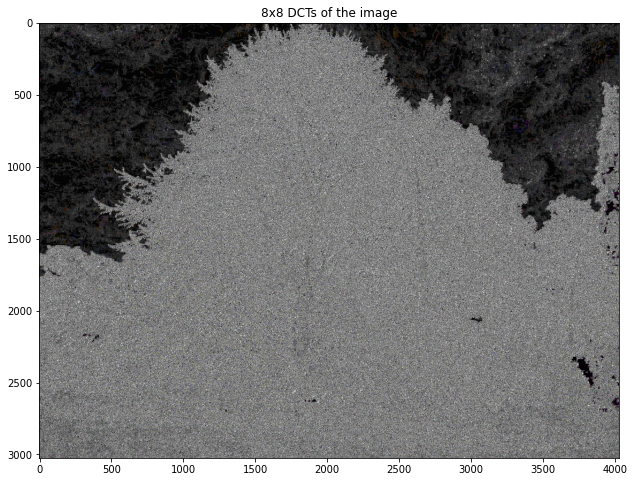

In [118]:
# Display entire DCT
dct_img = dctBlock(img)
plt.figure(figsize=(15, 8))
plt.imshow(dct_img)
plt.title( "8x8 DCTs of the image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Keeping only %26.882965924281233 of the DCT coefficients


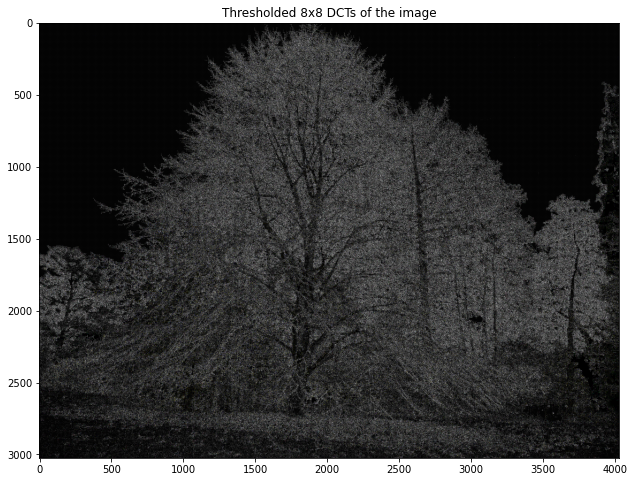

In [137]:
# Threshold DCT coefficients
dct_thresh = thresholdDCT(dct_img)
# show zero-out dct image
plt.figure(figsize=(15, 8))
plt.imshow(dct_thresh)
plt.title( "Thresholded 8x8 DCTs of the image")

dct_thresh = dct_thresh.astype(int) # covert to integer
nonZeros = np.sum(dct_thresh!=0) / (dct_thresh.shape[0]*dct_thresh.shape[1]*3)
print(f"Keeping only %{(nonZeros*100.0)} of the DCT coefficients")

In [168]:
dct_img[1800:1808,1800:1808,0].astype(int)

array([[501, -48, -33,  -2,  67,  19,  -6,   5],
       [-66,  80,  41,   0,  44,  13,   0,   5],
       [ 26,  36,  51, -27, -11,  -2,   1,  10],
       [ 27, -50,   4,   2,   0,   6,  -7,   9],
       [ 53,  22, -21,   9,  -5,   0,  -2,   0],
       [ 13,  25, -14,   4, -14,   5,   0,   7],
       [-25,   0,   6,  -1,  -3,  -7,   1,  -6],
       [  4, -14,   3,  -3,  -3,   0,   0, -13]])

In [167]:
dct_thresh[1800:1808,1800:1808,0]

array([[501, -48, -33,   0,  67,   0,   0,   0],
       [-66,  80,  41,   0,  44,   0,   0,   0],
       [ 26,  36,  51, -27,   0,   0,   0,   0],
       [ 27, -50,   0,   0,   0,   0,   0,   0],
       [ 53,  22, -21,   0,   0,   0,   0,   0],
       [  0,  25,   0,   0,   0,   0,   0,   0],
       [-25,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]])

In [76]:
len(pd.Series(dct_img.flatten()).unique()),len(pd.Series(dct_thresh.flatten()).unique())

(21972810, 2800)

In [68]:
(2800/21972810)*100

0.012743021943938896

         MSE   NRMSE      SSIM       PSNR  thresh  nonZeros%
0  98.805917  0.2247  0.830459  17.520684    0.01  26.882966


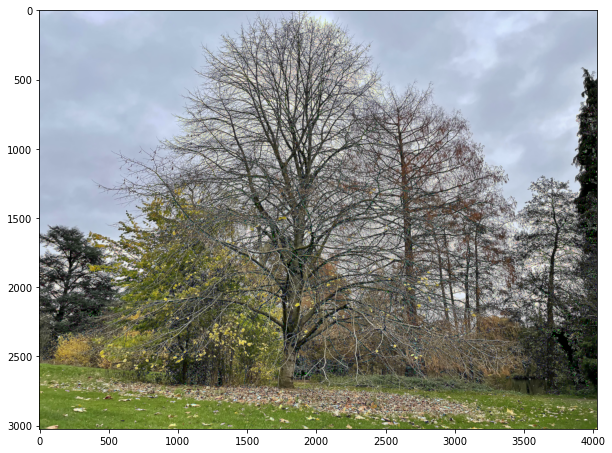

In [75]:
# Reconstruct image from quantized DCT coefficients
img_recon = idctBlock(dct_thresh)
df_res = printAll(img, img_recon)
df_res.loc[:,'thresh'] = 0.01
df_res.loc[:,'nonZeros%'] = nonZeros*100
print(df_res)
plt.figure(figsize=(10, 10))
plt.imshow(img_recon)

# Encoding Compression



In [19]:
# adapt from https://github.com/getsanjeev/compression-DCT/blob/master/zigzag.py
def zigzag(input):
    h,v = 0,0 # current position
    # image shape
    vmin, hmin = 0,0
    vmax, hmax = input.shape[:2]
    i = 0 # index
    output = np.zeros(( vmax * hmax)) # all pixels
    while ((v < vmax) and (h < hmax)): # while not reaching the end
        if ((h + v) % 2) == 0:  # even shape, going up
            if (v == vmin):
                output[i] = input[v, h]   # if we got to the first line
                if (h == hmax):
                    v+=1 # go down
                else:
                    h+=1  # go right               
                i+=1
            elif ((h == hmax-1 ) and (v < vmax)):   # if we got to the last column
            	output[i] = input[v, h] 
            	v+=1
            	i+=1
            elif ((v > vmin) and (h < hmax -1 )):   # all other cases
            	output[i] = input[v, h] 
            	v-=1
            	h+=1
            	i+=1
        else:                                    # odd shape, going down
        	if ((v == vmax -1) and (h <= hmax -1)): # if we got to the last line
        		output[i] = input[v, h] 
        		h+=1
        		i+=1
        	elif (h == hmin):                  # if we got to the first column
        		output[i] = input[v, h] 
        		if (v == vmax -1):
        			h+=1
        		else:
        			v+=1
        		i+=1
        	elif ((v < vmax -1) and (h > hmin)):     # all other cases
        		output[i] = input[v, h] 
        		v+=1
        		h-=1
        		i+=1
        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
        	output[i] = input[v, h] 
        	break
    #print ('v:',v,', h:',h,', i:',i)
    return output
def inverse_zigzag(input, vmax, hmax):
	h,v = 0,0 # current position
	# image shape
	vmin, hmin = 0,0
	output = np.zeros((vmax, hmax))
	i = 0
	while ((v < vmax) and (h < hmax)): 
		if ((h + v) % 2) == 0:                 # going up
			if (v == vmin):
				output[v, h] = input[i]        # if we got to the first line
				if (h == hmax):
					v+=1
				else:
					h+=1                        
				i+=1
			elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
				output[v, h] = input[i] 
				v+=1
				i+=1
			elif ((v > vmin) and (h < hmax -1 )):    # all other cases
				output[v, h] = input[i] 
				v-=1
				h+=1
				i+=1
		else:                                    # going down
			if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
				output[v, h] = input[i] 
				h+=1
				i+=1
			elif (h == hmin):                  # if we got to the first column
				output[v, h] = input[i] 
				if (v == vmax -1):
					h+=1
				else:
					v+=1
				i+=1
			elif((v < vmax -1) and (h > hmin)):     # all other cases
				output[v, h] = input[i] 
				v+=1
				h-=1
				i+=1
		if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
			output[v, h] = input[i] 
			break
	return output

In [20]:
# adopt zigzag for 3-channel image
def zigzag3D(input):
  bitlist=[]
  for c in range(3):
    bitlist.extend(zigzag(input[:,:,c])) # concat zigzag vector for each channel together
  return np.array(bitlist).astype(int)

def i_zigzag3D(input, vmax, hmax):
  list_3d = np.array(input).reshape(3,-1)
  i_zigzags = []
  for c in range(3):
    i_zigzags.append(inverse_zigzag(list_3d[c], vmax, hmax))
  return np.dstack(i_zigzags)

In [21]:
# run length encoding
def run_length_encoding(data): # input - np.array(zzCode).astype(int)
  encoding = ['']
  data = data.tolist()
  # while len(data)>0:
  #   e = data.pop(0)
  for e in tqdm(data):
    if e != 0:
      encoding.append(e)
    else:
      if (encoding[-1]=='X'): # if there is already a 0/X
        encoding[-1] = 'X2' # change the last encoding to X2 
      elif (not isinstance(encoding[-1],int)) and (len(encoding[-1]) > 1): # 
        encoding[-1] = 'X'+str(int(encoding[-1][1:]) + int(1))
      else:
        encoding.append('X')
  encoding = list(map(str, encoding))
  return ' '.join(encoding)[1:]

In [22]:
def i_run_length_encoding(strs): # inverse run length encoding
  codes = strs.split()
  data = []
  # while len(codes)>0:
  #   e = codes.pop(0)
  for e in tqdm(codes):
    if e[0] != 'X':
      data.append(int(e))
    elif e=='X':
      data.append(0)
    else:
      data.extend(np.zeros(int(e[1:])))
  return data

In [23]:
# save compressed codes to memory
def saveCodes(codes, thresh, color='RGB'): 
  t = str(thresh).split('.')[1]
  file = open(os.path.join(PATH,f"runLenCode_{color}_{t}"), "w")
  file.write(codes)
  file.close()

## Test RGB compress

In [36]:
# test various thresholds for RGB JPEG-DCT
dct_img = dctBlock(img) # get coefficients
df_res_all = [] # store all metrics
# delete/zero-out ratio: 30% 20% 10% 5% 1% 0.5% 0.1% of max value
for thresh in [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001]: 
  dct_thresh = thresholdDCT(dct_img,thresh).astype(int) # threshold value
  zzCode = zigzag3D(dct_thresh) # zigzag encoding
  runLenCode = run_length_encoding(zzCode) # run length encoding
  compressRatio = (img.shape[0]*img.shape[1]*3) / (len(runLenCode)) # calculate compression rate
  meta = str(img.shape[0])+' '+str(img.shape[1])+' '+str(img.shape[2])+'#' # add metadata
  runLenCode = meta+runLenCode
  saveCodes(runLenCode, thresh, 'RGB') # save codes
  # omit decoding there since its lossless 
  img_recon = idctBlock(dct_thresh).astype('uint8') # inverse blocking to reconstruct image

  plt.figure(figsize=(10, 10))
  plt.imshow(img_recon)
  plt.title('Deletion threshold='+str(thresh)+'@RGB')
  # calculate non-zero ratio
  nonZeros = np.sum(dct_thresh!=0) / (dct_thresh.shape[0]*dct_thresh.shape[1]*3)
  df_res = printAll(img, img_recon)
  df_res.loc[:,'Color'] = 'RGB'
  df_res.loc[:,'thresh'] = thresh
  df_res.loc[:,'nonZeros%'] = nonZeros*100
  df_res.loc[:,'Compress Ratio'] = compressRatio
  df_res_all.append(df_res)

Output hidden; open in https://colab.research.google.com to view.

In [37]:
res_rgb_test = pd.concat(df_res_all)
res_rgb_test.index = res_rgb_test.thresh
res_rgb_test

MSE     NRMSE      SSIM  ...  thresh  nonZeros%  Compress Ratio
thresh                                  ...                                   
0.500   228.020991  0.471093  0.317722  ...   0.500   0.789591       15.445406
0.400   227.098732  0.390574  0.341805  ...   0.400   0.978085       12.796060
0.300   225.452937  0.326941  0.364179  ...   0.300   1.184669       10.806097
0.200   222.860933  0.285330  0.401314  ...   0.200   1.433197        9.034872
0.100   216.104166  0.255403  0.526269  ...   0.100   2.302553        5.641620
0.050   202.627343  0.253843  0.657665  ...   0.050   5.125497        2.693450
0.010    98.805917  0.224700  0.830459  ...   0.010  26.882966        0.734930
0.005    28.436235  0.175712  0.887733  ...   0.005  41.726587        0.530912
0.001     2.214304  0.029637  0.991751  ...   0.001  65.879372        0.433538

[9 rows x 8 columns]

In [14]:
# define the final compressor and decompressor for RGB
def rgbCompress(img, thresh=0.01):
  dct_img = dctBlock(img)
  dct_thresh = thresholdDCT(dct_img,thresh).astype(int)
  nonZeros = np.sum(dct_thresh!=0) / (img.shape[0]*img.shape[1]*3) * 100
  zzCode = zigzag3D(dct_thresh)
  runLenCode = run_length_encoding(zzCode)
  compressRatio = (img.shape[0]*img.shape[1]*3) / (len(runLenCode))
  meta = str(img.shape[0])+' '+str(img.shape[1])+' '+str(img.shape[2])+'#'
  runLenCode = meta+runLenCode
  # saveCodes(runLenCode, thresh, 'RGB')
  print('Non-Zeros Ratio: %',nonZeros)
  print('Compession Ratio:',compressRatio)
  return runLenCode,nonZeros

def rgbDecompress(runLenCodes): # vmax=img.shape[0], hmax=img.shape[1]
  vmax, hmax = runLenCodes.split('#')[0].split()[:2]
  codes = runLenCodes.split('#')[1]
  reconCode = i_run_length_encoding(codes)
  dct_thresh = i_zigzag3D(reconCode, int(vmax), int(hmax))
  img_recon = idctBlock(dct_thresh).astype('uint8')
  return img_recon

In [42]:
runLenCode_rgb_2[0][:60]+'...'

'3024 4032 3#1580 X35 1573 X7 1590 X91 1567 X7 1577 X7 1590 X...'

In [24]:
runLenCode_rgb_2 = rgbCompress(img,thresh=0.2)[0]

100%|██████████| 36578304/36578304 [00:39<00:00, 936533.24it/s]

Non-Zeros Ratio: % 1.433196574668962
Compession Ratio: 9.034872321553616


In [92]:
runLenCode_rgb_01 = rgbCompress(img,thresh=0.01)[0]

100%|██████████| 36578304/36578304 [00:28<00:00, 1289438.22it/s]


Non-Zeros Ratio: % 26.882965924281233
Compession Ratio: 0.7349300311357156


## Test YCbCr compress

In [38]:
# YCbCr JPEG-DCT
img_ycbcr = rgb2ycbcr(img) # convert to YCbCr
dct_img_ycbcr = dctBlock(img_ycbcr)
df_res_all_ycbcr = [] # store all metrics
# delete/zero-out ratio: 30% 20% 10% 5% 1% 0.5% 0.1% of max value
for thresh in [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001]: 
  dct_thresh_ycbcr = thresholdDCT(dct_img_ycbcr,thresh).astype(int)
  zzCode = zigzag3D(dct_thresh_ycbcr) # zigzag encoding
  runLenCode = run_length_encoding(zzCode) # run length encoding
  compressRatio = (img.shape[0]*img.shape[1]*3) / (len(runLenCode)) # calculate compression rate
  meta = str(img.shape[0])+' '+str(img.shape[1])+' '+str(img.shape[2])+'#'
  runLenCode = meta+runLenCode
  saveCodes(runLenCode, thresh, 'YCbCr')

  img_recon_ycbcr = idctBlock(dct_thresh_ycbcr) # inverse blocking
  img_recon_ycbcr = ycbcr2rgb(img_recon_ycbcr).astype('uint8') # convert to rgb

  plt.figure(figsize=(10, 10))
  plt.imshow(img_recon_ycbcr)
  plt.title('Deletion threshold='+str(thresh)+'@YCbCr')
  # calculate non-zero ratio
  nonZeros = np.sum(dct_thresh_ycbcr!=0) / (dct_thresh_ycbcr.shape[0]*dct_thresh_ycbcr.shape[1]*3)
  df_res_ycbcr = printAll(img, img_recon_ycbcr)
  df_res_ycbcr.loc[:,'Color'] = 'YCbCr'
  df_res_ycbcr.loc[:,'thresh'] = thresh
  df_res_ycbcr.loc[:,'nonZeros%'] = nonZeros*100
  df_res_ycbcr.loc[:,'Compress Ratio'] = compressRatio
  df_res_all_ycbcr.append(df_res_ycbcr)

Output hidden; open in https://colab.research.google.com to view.

In [39]:
res_ycbcr_test = pd.concat(df_res_all_ycbcr)
res_ycbcr_test.index = res_ycbcr_test.thresh
res_ycbcr_test

MSE     NRMSE      SSIM  ...  thresh  nonZeros%  Compress Ratio
thresh                                  ...                                   
0.500   293.662977  0.613190  0.243016  ...   0.500   0.828426       14.842766
0.400   231.016292  0.384895  0.346216  ...   0.400   1.336648        9.684207
0.300   224.712711  0.316192  0.377057  ...   0.300   1.460472        8.946083
0.200   222.961763  0.280787  0.410515  ...   0.200   1.537808        8.517005
0.100   217.974068  0.253277  0.533300  ...   0.100   1.823802        7.173345
0.050   204.307679  0.247042  0.669411  ...   0.050   2.781972        4.875244
0.010   108.301588  0.201741  0.862032  ...   0.010  10.160884        1.846598
0.005    46.268918  0.146967  0.922601  ...   0.005  15.332414        1.369225
0.001    19.347024  0.034382  0.988666  ...   0.001  26.028618        1.003428

[9 rows x 8 columns]

In [31]:
# define the final compressor / decompressor for YCbCr
def ycbcrCompress(img, thresh=0.01):
  img_ycbcr = rgb2ycbcr(img)
  dct_img_ycbcr = dctBlock(img_ycbcr)
  dct_thresh_ycbcr = thresholdDCT(dct_img_ycbcr,thresh).astype(int)
  nonZeros = np.sum(dct_thresh_ycbcr!=0) / (img.shape[0]*img.shape[1]*3)*100
  zzCode = zigzag3D(dct_thresh_ycbcr)
  runLenCode = run_length_encoding(zzCode)
  compressRatio = (img.shape[0]*img.shape[1]*3) / (len(runLenCode))
  meta = str(img.shape[0])+' '+str(img.shape[1])+' '+str(img.shape[2])+'#'
  runLenCode = meta+runLenCode
  # saveCodes(runLenCode, thresh, 'YCbCr')
  print('Non-Zeros Ratio: %',nonZeros)
  print('Compession Ratio:',compressRatio)
  return runLenCode,nonZeros

def ycbcrDecompress(runLenCodes): # vmax=img.shape[0], hmax=img.shape[1]
  vmax, hmax = runLenCodes.split('#')[0].split()[:2]
  codes = runLenCodes.split('#')[1]
  reconCode = i_run_length_encoding(codes)
  dct_thresh_ycbcr = i_zigzag3D(reconCode, int(vmax), int(hmax))
  img_recon_ycbcr = idctBlock(dct_thresh_ycbcr)
  img_recon_ycbcr = ycbcr2rgb(img_recon_ycbcr).astype('uint8')
  return img_recon_ycbcr

In [28]:
runLenCode_y_2 = ycbcrCompress(img,thresh=0.2)[0]

100%|██████████| 36578304/36578304 [00:41<00:00, 877234.60it/s]


Non-Zeros Ratio: % 1.543103255962879
Compession Ratio: % 11.759826262037738


In [29]:
runLenCode_y_3 = ycbcrCompress(img,thresh=0.3)[0]

100%|██████████| 36578304/36578304 [00:40<00:00, 907037.62it/s]


Non-Zeros Ratio: % 1.5090038072842304
Compession Ratio: % 11.518191220675513


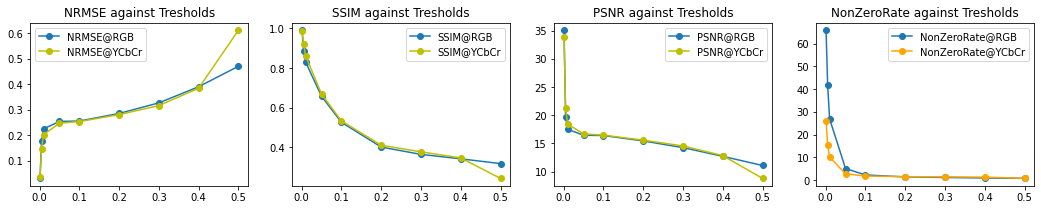

In [53]:
# visulize results
def visRes(res_rgb,res_ycbc):
  plt.figure(figsize=(18, 3))
  plt.subplot("141")
  plt.plot(res_rgb['NRMSE'],'o-')
  plt.plot(res_ycbc['NRMSE'],'o-y')
  plt.legend(['NRMSE@RGB','NRMSE@YCbCr'])
  plt.title('NRMSE against Tresholds')
  plt.subplot("142")
  plt.plot(res_rgb['SSIM'],'o-')
  plt.plot(res_ycbc['SSIM'],'o-y')
  plt.legend(['SSIM@RGB','SSIM@YCbCr'])
  plt.title('SSIM against Tresholds')
  plt.subplot("143")
  plt.plot(res_rgb['PSNR'],'o-')
  plt.plot(res_ycbc['PSNR'],'o-y')
  plt.legend(['PSNR@RGB','PSNR@YCbCr'])
  plt.title('PSNR against Tresholds')
  plt.subplot("144")
  plt.plot(res_rgb['nonZeros%'],'o-')
  plt.plot(res_ycbc['nonZeros%'],'o-',color='orange')
  plt.legend(['NonZeroRate@RGB','NonZeroRate@YCbCr'])
  plt.title('NonZeroRate against Tresholds')
visRes(res_rgb_test,res_ycbcr_test)

Text(0.5, 1.0, 'CompressRatio against Tresholds')

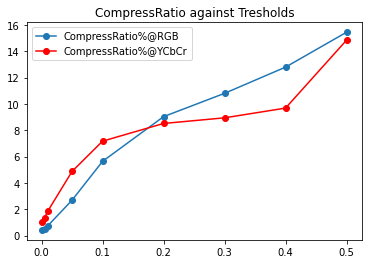

In [42]:
# plot compression ratio
plt.plot(res_rgb_test['Compress Ratio'],'o-')
plt.plot(res_ycbcr_test['Compress Ratio'],'o-r')
plt.legend(['CompressRatio%@RGB','CompressRatio%@YCbCr'])
plt.title('CompressRatio against Tresholds')

# Decompressed Details Evaluation

100%|██████████| 1048278/1048278 [00:03<00:00, 288605.26it/s]


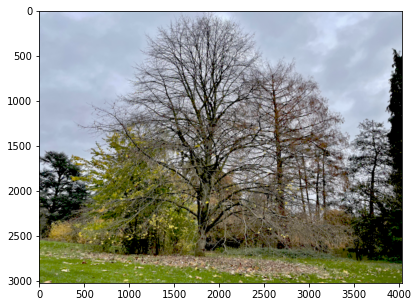

In [108]:
recon = rgbDecompress(runLenCode_rgb_2[0])
plt.figure(figsize=(8, 5))
plt.imshow(recon)

Text(0.5, 1.0, 'Reconstructed Image Details')

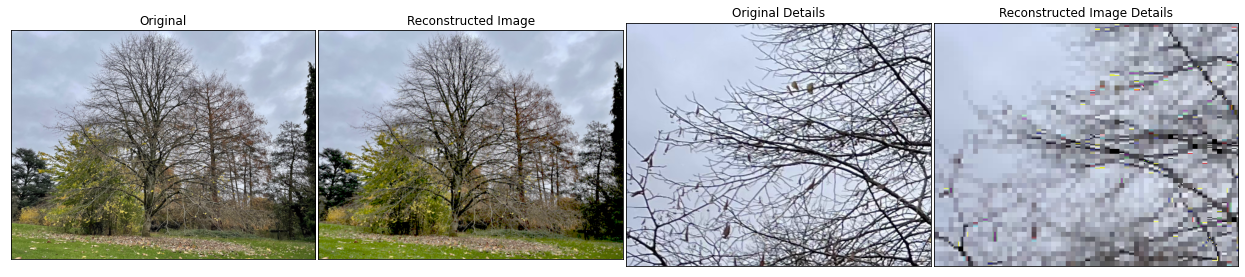

In [113]:
# show decompressed details
plt.figure(figsize=(22, 5))
plt.subplots_adjust(wspace=0.01, hspace=0.08)
plt.subplot('141')
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.title('Original')
plt.subplot('142')
plt.imshow(recon)
plt.xticks([]), plt.yticks([])
plt.title('Reconstructed Image')
plt.subplot('143')
plt.imshow(img[800:1200,800:1300,:])
plt.xticks([]), plt.yticks([])
plt.title('Original Details')
plt.subplot('144')
plt.imshow(recon[800:1200,800:1300,:])
plt.xticks([]), plt.yticks([])
plt.title('Reconstructed Image Details')

Text(0.5, 1.0, 'Reconstructed IC5/t=0.2@RGB')

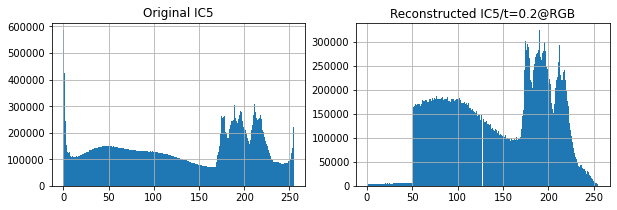

In [117]:
# show histogram
plt.figure(figsize=(10, 3))
plt.subplot('121')
pd.Series(img.flatten()).hist(bins=256)
plt.title('Original IC5')
plt.subplot('122')
pd.Series(recon.flatten()[recon.flatten()!=0]).hist(bins=256)
plt.title('Reconstructed IC5/t=0.2@RGB')

In [50]:
pd.Series(runLenCode_rgb_2[0].split()).value_counts().sort_values(ascending=False).head(30)

X7      472325
X15      16445
X23       5613
X31       2888
X39       1924
1400      1853
1520      1795
1696      1786
1408      1458
1416      1429
X47       1412
1568      1343
1424      1331
1688      1263
1704      1237
1488      1236
1560      1215
1432      1190
1576      1180
1392      1142
1496      1134
1744      1130
1512      1098
1728      1078
1552      1071
1504      1067
1480      1061
1528      1055
1736      1050
X55       1037
dtype: int64

# Batch Compression

  6%|▌         | 58702/988204 [00:00<00:03, 287195.38it/s]

Non-Zeros Ratio: % 1.3508062046835194
Compession Ratio: 9.418957290077937


  4%|▍         | 39941/895711 [00:00<00:04, 174696.66it/s]

Non-Zeros Ratio: % 1.2243733334383136
Compession Ratio: 10.403539529026027


  5%|▌         | 51414/973194 [00:00<00:03, 265666.85it/s]

Non-Zeros Ratio: % 1.330288577622407
Compession Ratio: 9.590865339108396


  7%|▋         | 52981/788872 [00:00<00:02, 262492.76it/s]

Non-Zeros Ratio: % 1.078355081744632
Compession Ratio: 11.781385578374325


  6%|▋         | 55112/866664 [00:00<00:02, 274129.61it/s]

Non-Zeros Ratio: % 1.1846694696397078
Compession Ratio: 10.806097190254919


100%|██████████| 866664/866664 [00:03<00:00, 255282.02it/s]


IC1         IC2  ...         IC5     Average
MSE                173.002591  184.852352  ...  225.452937  200.688086
NRMSE                0.177283    0.209941  ...    0.326941    0.253904
SSIM                 0.533648    0.478883  ...    0.364179    0.438345
PSNR                18.821384   17.835452  ...   14.263362   16.782355
Non-Zero Ratio%      1.350806    1.224373  ...    1.184669    1.233699
Compression Ratio    9.418928   10.403504  ...   10.806059   10.400133

[6 rows x 6 columns]

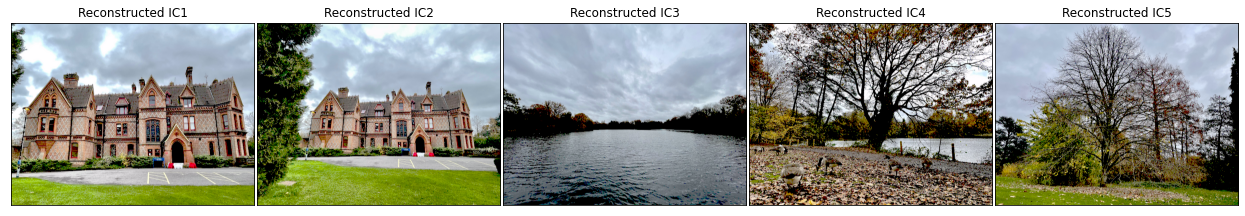

In [35]:
# RGB, treshold=0.3
PATH = "drive/MyDrive/PY/2020_Projects/ImgAnalysis/ImgCompress/2020_images_BMP"
thresh = 0.3
df_res = []
compressRatio =[]
nonZerosRatio = []
plt.figure(figsize=(22, 4))
plt.subplots_adjust(wspace=0.01, hspace=0.08)
for i in range(1,6):
  FILE = f"IC{i}.bmp"
  img = imread(os.path.join(PATH,FILE))
  runLenCode_y, nonZeros = rgbCompress(img,thresh=thresh)
  img_recon = rgbDecompress(runLenCode_y)
  df_res.append(printAll(img, img_recon))
  nonZerosRatio.append(nonZeros)
  compressRatio.append((img.shape[0]*img.shape[1]*3) / (len(runLenCode_y)))
  plt.subplot(f"15{i}")
  plt.imshow(img_recon)
  plt.title(f"Reconstructed IC{i}")
  plt.xticks([]), plt.yticks([])
#0.3 RGB
df_res5 = pd.concat(df_res)
df_res5.index = ['IC1','IC2','IC3','IC4','IC5']
df_res5.loc[:,'Non-Zero Ratio%'] = nonZerosRatio
df_res5.loc[:,'Compression Ratio'] = compressRatio
df_res5T = df_res5.T
df_res5T.loc[:,'Average'] = list(np.mean(df_res5))
df_res5T

  2%|▏         | 28785/1182232 [00:00<00:04, 287458.25it/s]

Non-Zeros Ratio: % 1.6173221153173205
Compession Ratio: % 8.098585028790277


  2%|▏         | 25299/1180684 [00:00<00:04, 252983.61it/s]

Non-Zeros Ratio: % 1.6166796579743008
Compession Ratio: % 8.190490350536997


  2%|▏         | 22513/1164560 [00:00<00:05, 225127.53it/s]

Non-Zeros Ratio: % 1.5924494476288458
Compession Ratio: % 8.208491896824032


  2%|▏         | 33616/1426014 [00:00<00:04, 336159.52it/s]

Non-Zeros Ratio: % 1.9800453296030345
Compession Ratio: % 6.587602882038801


  2%|▏         | 31733/1323572 [00:00<00:04, 317328.79it/s]

Non-Zeros Ratio: % 1.8238024376417232
Compession Ratio: % 7.173344514176543


100%|██████████| 1323572/1323572 [00:04<00:00, 325917.45it/s]


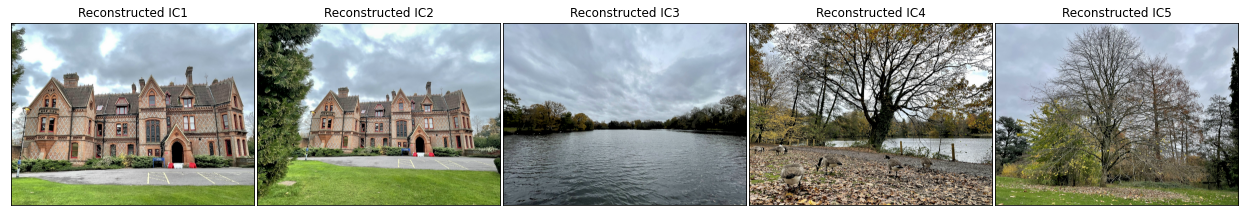

In [27]:
# YCbCr， threshold=0.1
PATH = "drive/MyDrive/PY/2020_Projects/ImgAnalysis/ImgCompress/2020_images_BMP"
thresh = 0.1
df_res = []
compressRatio =[]
plt.figure(figsize=(22, 4))
plt.subplots_adjust(wspace=0.01, hspace=0.08)
for i in range(1,6):
  FILE = f"IC{i}.bmp"
  img = imread(os.path.join(PATH,FILE))
  runLenCode_y = ycbcrCompress(img,thresh=thresh)
  img_recon = ycbcrDecompress(runLenCode_y)
  df_res.append(printAll(img, img_recon))
  compressRatio.append((img.shape[0]*img.shape[1]*3) / (len(runLenCode_y)))
  plt.subplot(f"15{i}")
  plt.imshow(img_recon)
  plt.title(f"Reconstructed IC{i}")
  plt.xticks([]), plt.yticks([])
  
df_res5 = pd.concat(df_res)

In [28]:
df_res5.index = ['IC1','IC2','IC3','IC4','IC5']
df_res5.loc[:,'Non-Zero Ratio%'] = [1.6173221153173205,1.6166796579743008,1.5924494476288458,1.9800453296030345,1.8238024376417232]
# df_res5.loc[:,'Compression Ratio%'] = [12.347836028701604,12.209281217631085,12.18250578266286,15.180028576502618,13.940498717491112]
df_res5.loc[:,'Compression Ratio'] = compressRatio
df_res5T = df_res5.T
df_res5T.loc[:,'Average'] = list(np.mean(df_res5))
df_res5T

IC1         IC2  ...         IC5     Average
MSE                164.339694  173.987549  ...  217.974068  191.804529
NRMSE                0.124325    0.138872  ...    0.253277    0.194182
SSIM                 0.632949    0.589837  ...    0.533300    0.573735
PSNR                21.903585   21.425146  ...   16.480806   19.551166
Non-Zero Ratio%      1.617322    1.616680  ...    1.823802    1.726060
Compression Ratio    8.098564    8.190468  ...    7.173328    7.651684

[6 rows x 6 columns]

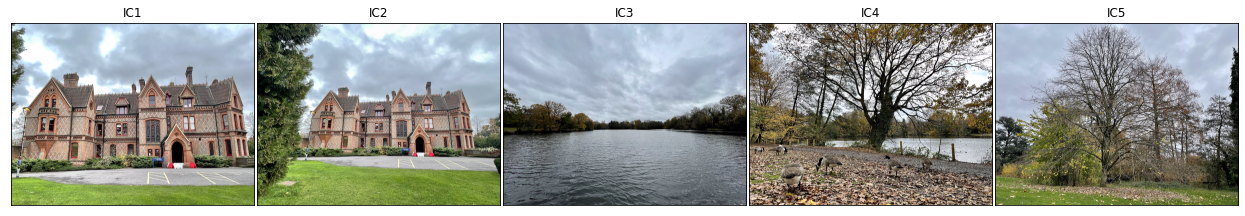

In [121]:
# show original 5 images
plt.figure(figsize=(22, 4))
plt.subplots_adjust(wspace=0.01, hspace=0.08)
for i in range(1,6):
  FILE = f"IC{i}.bmp"
  img = imread(os.path.join(PATH,FILE))
  plt.subplot(f"15{i}")
  plt.imshow(img)
  plt.title(f"IC{i}")
  plt.xticks([]), plt.yticks([])


# Wavelet Test

In [ ]:
import pywt
def waveDecRGB(img, level=2, wavelet='db1'):
  coefs = []
  for c in range(3): # for each RGB channel 
    coefs.append(pywt.wavedec2(img[:,:,c], wavelet=wavelet, level=level)) # use wavelet to decompose
  return coefs

def coefArrRGB(coefs):
  coef_arr, coef_slices = [0,1,2], [0,1,2]
  for c in range(3):
    # Arrange a wavelet coefficient list from wavedecn into a single array
    coef_arr[c], coef_slices[c] = pywt.coeffs_to_array(coefs[c]) 
  return coef_arr, coef_slices


MSE     NRMSE      SSIM       PSNR  threshold  nonZeros
0  269.680813  0.086842  0.865426  25.020125      0.100  9.994127
0  299.914596  0.130681  0.769927  21.470487      0.050  5.003422
0  317.003670  0.170445  0.602745  19.163039      0.010  0.999822
0  291.181123  0.149465  0.540888  20.303958      0.005  0.500031
0  255.336520  0.736203  0.206402   6.454792      0.001  0.099403

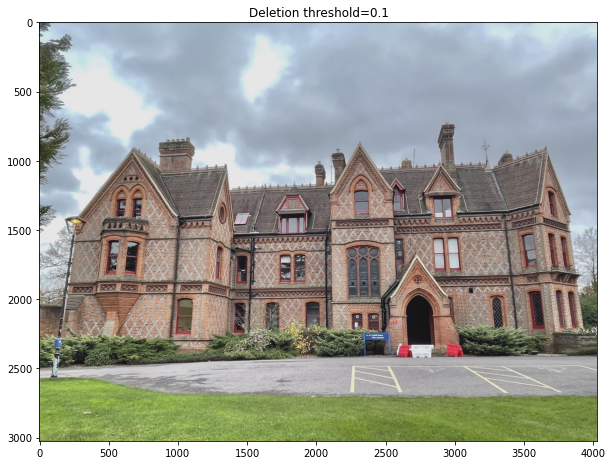

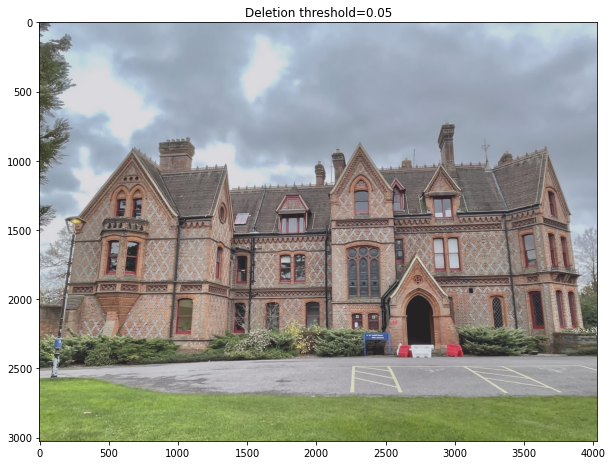

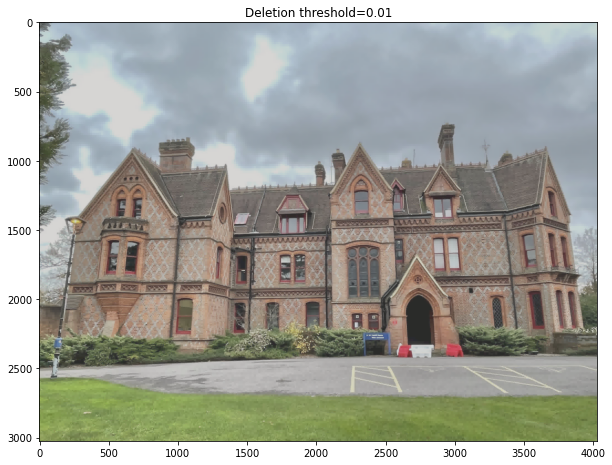

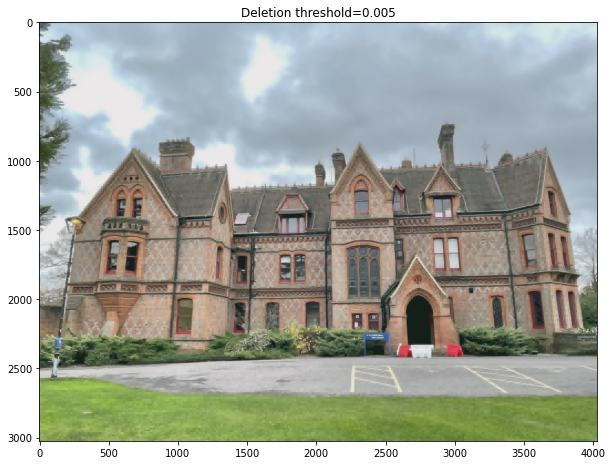

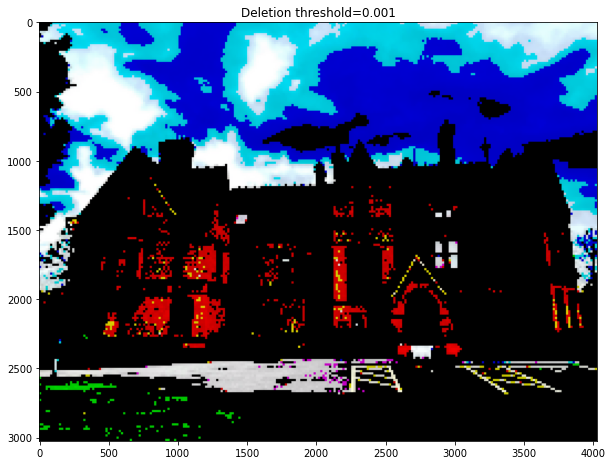

In [ ]:
# use the mean threshold of each channel
def waveCompress(img, thresh=0.01, level=4, wavelet='db1'): # default deletion threshold: 0.01
  coefs = waveDecRGB(img, level, wavelet)
  coef_arr, coef_slices = coefArrRGB(coefs) # coef to array 
  csortRGB = [np.sort(np.abs(coef.reshape(-1))) for coef in coef_arr] # for each channel sort intensity value
  thresholdRGB = [csort[int(np.floor((1-thresh)*len(csort)))] for csort in csortRGB] # zero-out threshold for RGB
  arrRGB_masked = coef_arr * (np.abs(np.array(coef_arr)) > np.mean(thresholdRGB))  # coef_arr * (mask),use the mean threshold of RGB
  dataRGB_compressed = [pywt.array_to_coeffs(arrRGB_masked[c], coef_slices[c], output_format='wavedec2') for c in range(3)]
  # return compressed coefs, and non-zero rate
  return dataRGB_compressed, (np.sum(arrRGB_masked!=0) / (img.shape[0]*img.shape[1]*3))*100

def waveRecon(data, wavelet='db1'):
  img_reconRGB = [pywt.waverec2(channel, wavelet) for channel in dataRGB_compressed]
  img_reconRGB = [minMaxScaler(c) for c in img_reconRGB]
  img_recon = np.dstack(img_reconRGB).astype('uint8')
  return img_recon

df_res_wave = []
for thresh in [0.1, 0.05, 0.01, 0.005, 0.001]: # 10% 5% 1% 0.5% 0.1% 
  dataRGB_compressed, nonZeros = waveCompress(img, thresh, level=4, wavelet='db1')
  nonZero = np.sum(dataRGB_compressed!=0) / (img.shape[0]*img.shape[1]*3)
  img_recon = waveRecon(dataRGB_compressed, wavelet='db1')
  df_res = printAll(img, img_recon)
  df_res.loc[:,'threshold'] = thresh
  df_res.loc[:,'nonZeros'] = nonZeros
  df_res_wave.append(df_res)
  plt.figure(figsize=(10, 10))
  plt.imshow(img_recon)
  plt.title('Deletion threshold='+str(thresh))
pd.concat(df_res_wave)